# Detecting Bias on Reddit Using NLP Analysis and Linear Regression

Included in this notebook is data cleaning, visualizations, NLP analysis and the process of modeling with linear regression. The aim of this notebook is to detect bias in the news that Redditors receive while browsing the world news. This is done by seeing if certain features, specifically certain terms, can influence the amount of upvotes a world news post receives on Reddit. The number of upvotes influences how visible an article becomes on Reddit, so if a post initially receives many upvotes or downvotes because of the topic of the post, then those topics will be more or less likely to be seen by the average Reddit user.

The final model for the analysis was made using linear regression.

* Target Variable:
    * Logged upvotes
* Feature Variables:
    * Article word counts
    * Article TFIDF
    * Linked website
    * Time posted
    * Age of post
    * Title length

Section breakdown:

1. Import Libraries
2. Import Dataframes
3. Data Cleaning and Feature Engineering
4. Feature Engineering
5. Analyze the "Upvote" Variable
6. Create Dummy Variables
7. Convert Text Data to Sparse Matrix Using Count Vectorizer
8. Convert Text Data to Sparse Matrix Using Tfidf Vectorizer
9. Variables
10. Make Potential Dataframes 
11. Regressions
12. Top Word Distributions

# 1. Import Libraries

In [2]:
# Data Manipulation 
import pandas as pd
import numpy as np
import datetime
import scipy.stats as stats

# NLP Analysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Linear Regression 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

# 2. Import Data
 Obtained from web scraping (scraped multiple times to obtain more data as Reddit only saves a certain amount locally)

In [3]:
df1 = pd.read_csv('raw_data/post_data_10_4.csv',index_col='Unnamed: 0')
df2 = pd.read_csv('raw_data/post_data_10_6.csv',index_col='Unnamed: 0')
df3 = pd.read_csv('raw_data/post_data_10_7.csv',index_col='Unnamed: 0')
df4 = pd.read_csv('raw_data/post_data_10_8.csv',index_col='Unnamed: 0')
df5 = pd.read_csv('raw_data/post_data_10_9.csv',index_col='Unnamed: 0')
df6 = pd.read_csv('raw_data/post_data_10_10.csv',index_col='Unnamed: 0')

In [4]:
df = pd.concat([df6,df5,df4,df3,df2,df1])

In [5]:
# Remove all the duplicate posts that were overlapping due to the manner in which the data was obtained
# Deletes the older posts so the posts with more upvotes, comments, etc are saved
df = df.drop_duplicates(subset=['title']).reset_index(drop=True)

In [6]:
df.head()

,upvotes,title,site,time_posted,post_age,comment_no
0,0,The Far Right Isn’t the Only Rising Force in G...,theatlantic.com,2018-10-10 18:49:33,0 days 00:02:20.444008000,0
1,0,Mexico: Mayor accused of spending taxpayers' m...,mexiconewsdaily.com,2018-10-10 18:48:57,0 days 00:02:56.444011000,0
2,0,Chinese spy charged with stealing U.S. militar...,washingtonpost.com,2018-10-10 18:48:22,0 days 00:03:31.444012000,1
3,0,Mexico: 5 Mexico City police arrested for stea...,mexiconewsdaily.com,2018-10-10 18:43:55,0 days 00:07:58.444012000,0
4,0,Mexico: World Justice Project study finds weak...,mexiconewsdaily.com,2018-10-10 18:40:32,0 days 00:11:21.444013000,1


# 3. Data Cleaning (Non-text features)
* Convert the time posted to datetime
* Convert the age of the post to a timedelta
* Delete posts under three hours
    * In this way, posts that haven't had enough time for maximum upvote potential aren't taken into account

In [8]:
# Convert to datetime
df['time_posted'] = pd.to_datetime(df['time_posted'])

In [9]:
# Convert post age to timedelta
def to_timedelta(item):
    return pd.Timedelta(item[:-10])

df['post_age'] = df['post_age'].apply(to_timedelta)

In [42]:
# Delete posts under three hours
df = df[df.post_age >= three_hours].reset_index(drop=True)

# 4. Feature Engineering

Feautres created:
* The hour of day that the post was made
    * The time of day could impact upvote volume, as the volume of Reddit users changes throughout the day
* Post title length
    * This feature could affect the number of upvotes as shorter titles could be easier to read. Or longer titles could contain more interesting information

In [10]:
# Hour of day that the post was made
def to_hour(item):
    return item.hour

df['hour_posted'] = df['time_posted'].apply(to_hour)

In [14]:
# Post title length
def length(item):
    sentence = item.split(" ")
    return len(sentence)

df['title_length'] = df['title'].apply(length)

In [15]:
df.head()

,upvotes,title,site,time_posted,post_age,comment_no,hour_posted,title_length
0,7,Soaring Rice Prices Are Dulling Duterte’s Lust...,nytimes.com,2018-10-10 15:49:49,03:02:05,2,15,9
1,11,Man who sold stolen identities sentenced to pr...,reuters.com,2018-10-10 15:38:01,03:13:53,2,15,11
2,42,China okays massive re-education camps for Mus...,businessinsider.com,2018-10-10 15:35:19,03:16:35,8,15,13
3,17,Indonesian tourists vandalize Olmec monumental...,theyucatantimes.com,2018-10-10 15:28:44,03:23:10,5,15,8
4,5,UNESCO: Rachel's Tomb and Cave of Patriarchs p...,jpost.com,2018-10-10 15:27:11,03:24:43,7,15,11


# 5. Analyze the "Upvote" Variable

This is the target variable, so analysis of the variable is key.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


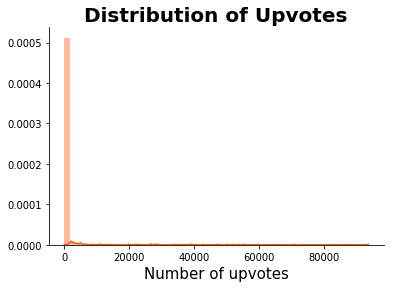

In [16]:
# Plot the distribution 
upvotes = df['upvotes'].values
sns.distplot(upvotes, color= '#FF5700');
plt.title('Distribution of Upvotes', fontsize = 20, weight = 'bold')
plt.xlabel('Number of upvotes', fontsize = 15)
sns.despine();

In [17]:
df['upvotes'].describe()

count     2254.000000
mean       887.414818
std       6084.253352
min          0.000000
25%          5.000000
50%         12.000000
75%         39.000000
max      93700.000000
Name: upvotes, dtype: float64

This is a very skewed distribution and needs to be normalized. In terms of regression, this will mean that the model can no longer predict a concrete amount of upvotes. Thankfully, we are more interested in upvotes on posts relative to other posts and than the actual score on each post, so this doesn't change the problem.

In [18]:
# Create a logged upvotes variable 
df["upvotes_logged"] = np.log1p(df.upvotes)

In [20]:
# Create a double logged upvotes variable
df['double_log'] = np.log1p(df.upvotes_logged)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


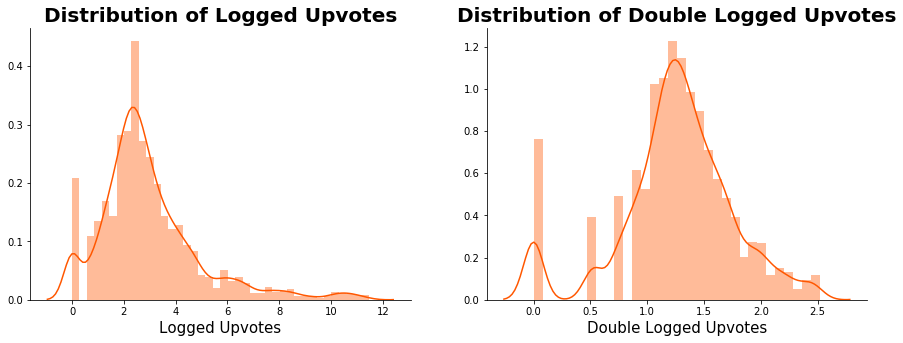

In [29]:
# Plot the distribution of logged upvotes

plt.figure(figsize=[15,5])

plt.subplot(1,2,1)
sns.distplot(df['upvotes_logged'], color= '#FF5700')
plt.title('Distribution of Logged Upvotes', fontsize = 20, weight = 'bold')
plt.xlabel('Logged Upvotes', fontsize = 15)
sns.despine();


plt.subplot(1,2,2)
sns.distplot(df['double_log'], color= '#FF5700')
plt.title('Distribution of Double Logged Upvotes', fontsize = 20, weight = 'bold')
plt.xlabel('Double Logged Upvotes', fontsize = 15)
sns.despine();

In [23]:
df.describe()

,upvotes,post_age,comment_no,hour_posted,title_length,upvotes_logged,double_log
count,2254.000000,2254,2254.000000,2254.000000,2254.000000,2254.000000,2254.000000
mean,887.414818,1 days 22:16:57.894853,70.420586,11.685892,14.936114,2.974696,1.262807
std,6084.253352,0 days 21:05:25.488515,394.964544,5.935801,10.077216,1.973716,0.498840
min,0.000000,0 days 03:02:05,0.000000,0.000000,4.000000,0.000000,0.000000
25%,5.000000,1 days 07:37:58.750000,1.000000,7.000000,9.000000,1.791759,1.026672
50%,12.000000,2 days 01:54:15,4.000000,12.000000,11.000000,2.564949,1.271150
75%,39.000000,2 days 13:51:39,13.000000,16.000000,15.000000,3.688879,1.545194
max,93700.000000,3 days 12:32:14,7730.000000,23.000000,53.000000,11.447864,2.521549


The distributions of both the logged and double logged upvotes are much closer to normal distributions than the original variable's. Because taking the double log creates quite a disproportionate amount of 0s, it makes sense to use the logged upvotes as the target.

# 6. Create Dummy Variables 

Dummy variables created:
* Linked Sites:
    * The original source of the news article posted on Reddit
    * This feature could impact upvotes as some sites may be more credible or favored on Reddit
* Time of Day Posted:
    * The hour of the day that the post was created (saved as numbers, where each number represents an hour in a 24 hour clock)
    * While there's already a "Time of Day Posted" variable, treating it as a dummy variable rather than a continuous one could combat the value of the hour of the day being treated as numerical and averaging out.
* Age of the Post:
    * How long the post had been up before the data was scraped
    * While posts that were too new were already removed, time is definitely a factor in the number of upvotes as the longer a post has been up, the more opportunity it has to receive upvotes

In [43]:
# Dummy variables for each linked site

In [31]:
sites_dummy = pd.get_dummies(df['site'])
# Drop infrequently used sites to prevent overfitting
sites_dummy.drop([col for col, val in sites_dummy.sum().iteritems() if val < 15], axis=1, inplace=True)

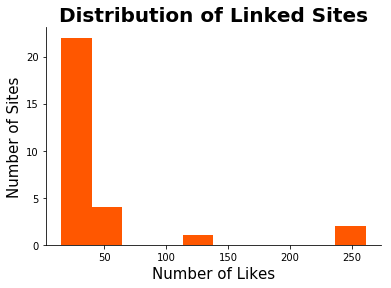

In [40]:
# Plot the distribution
plt.hist(sites_dummy.sum(), color= '#FF5700')
plt.title('Distribution of Linked Sites', fontsize = 20, weight = 'bold')
plt.xlabel('Number of Likes', fontsize = 15)
plt.ylabel('Number of Sites', fontsize = 15)
sns.despine();

In [41]:
sites_dummy.sum().sort_values(ascending=False)

reuters.com            261
theguardian.com        246
bbc.com                130
bbc.co.uk               62
independent.co.uk       49
aljazeera.com           46
dw.com                  45
edition.cnn.com         37
cbc.ca                  34
apnews.com              32
nytimes.com             31
cnbc.com                31
washingtonpost.com      26
timesofisrael.com       24
news.sky.com            24
abc.net.au              24
bloomberg.com           23
thedailybeast.com       23
cnn.com                 21
japantimes.co.jp        20
channelnewsasia.com     19
businessinsider.com     19
abcnews.go.com          19
scmp.com                17
france24.com            16
themoscowtimes.com      16
en.crimerussia.com      15
euractiv.com            15
dailymail.co.uk         15
dtype: int64

The sites listed above are the most frequently listed. Reuters, The Guardian, and BBC are by far the most commonly linked sites.

In [27]:
# Time posted dummy variables

In [28]:
hour_dummy = pd.get_dummies(df['hour_posted'])

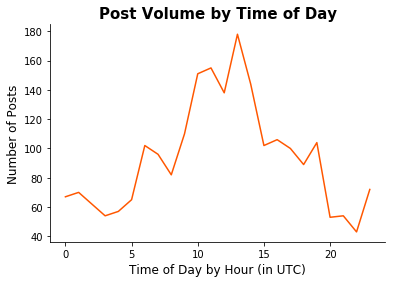

In [29]:
# Plot the posts by time of day
hour_dummy.sum().plot(color= '#FF5700')
plt.title('Post Volume by Time of Day', fontsize = 15, weight = 'bold')
plt.ylabel('Number of Posts', fontsize = 12)
plt.xlabel('Time of Day by Hour (in UTC)', fontsize = 12)
sns.despine();

Most Reddit users seem to post at UTC 13:00, which could be first thing in the morning for a large portion of the users.

In [30]:
# Post age dummy variables

In [44]:
# Make bins in increments of 5 hours with labels
bins = []
labels = []
for item in range(0,90,5):
    string = str(item) + 'hours'
    bins.append(pd.Timedelta(string))
    labels.append(item)
    
labels = labels[1:]

In [45]:
# Categorize each post into a bin
df['post_age_hours'] = pd.cut(df['post_age'], bins=bins, labels=labels)

In [46]:
# Create the dummy variables
age_dummy = pd.get_dummies(df['post_age_hours'])

# 7. Convert Text Data to Sparse Matrix Using Count Vectorizer

In [34]:
# Convert title to only letters
df['title'] = df['title'].str.replace('[^a-z, A-Z]', '')

In [35]:
count_vect = CountVectorizer(stop_words = 'english', ngram_range=(1, 2))
counts = count_vect.fit_transform(df['title'])

In [36]:
counts.shape

(2254, 24153)

In [37]:
# Create a sparse matrix with the counts
def wm2df(wm, feat_names):
    doc_names = ['{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)
tokens = count_vect.get_feature_names()
count_words_df = wm2df(counts, tokens)

In [38]:
common_words = count_words_df.sum().sort_values()

In [39]:
# See common words
common_words.tail(10)

trump       70
india       72
said        77
russia      79
russian     86
uk          96
saudi      107
new        128
china      141
says       176
dtype: int64

In [40]:
# Sparse matrix without seldom used words
word_series = common_words.loc[common_words >= 10]
word_list = list(word_series.index.values)
select_count = count_words_df[word_list]

In [41]:
# Create a variable that is the number of top words used divided by length of the post
select_count['sum'] = select_count.sum(axis=1)
count_whole_df = pd.concat([df.reset_index(drop=True), select_count.reset_index(drop=True)], axis= 1)
count_whole_df["average"] = (count_whole_df["sum"]/count_whole_df["title_length"])
count_avg = count_whole_df["average"]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# 8. Convert Text Data to Sparse Matrix Using Tfidf Vectorizer

In [42]:
count_vect = TfidfVectorizer(stop_words = 'english', ngram_range=(1, 2))
counts = count_vect.fit_transform(df['title'])

In [43]:
tokens = count_vect.get_feature_names()
tfidf_words_df = wm2df(counts, tokens)

In [44]:
common_words = tfidf_words_df.sum().sort_values()

In [45]:
common_words.tail(10)

north      10.447365
trump      10.719499
india      12.184080
russian    12.591774
russia     12.684590
uk         12.688546
new        14.570317
saudi      15.682268
china      19.247975
says       21.184221
dtype: float64

In [46]:
# Sparse matrix without seldom used words
word_series = common_words.loc[common_words >= 1.4]
word_list = list(word_series.index.values)
select_tfidf = tfidf_words_df[word_list]

In [47]:
# Create a variable that is the number of top words used divided by length of the post
tfidf_words_df['sum'] = tfidf_words_df.sum(axis=1)
tfidf_avg = tfidf_words_df["sum"]

# 9. Variables

For convenience, all variables listed below.

In [48]:
upvote_df = df['upvotes']
log_upvote_df = df['upvotes_logged']
len_df = df['title_length']
time_df = df['time_posted']
df_age = pd.concat([df, age_dummy], axis = 1)
age_df = df['post_age']
comment_df = df['comment_no']

In [49]:
# df

# upvote_df
# log_upvote_df
# double_log

# count_words_df
# select_count
# count_avg

# tfidf_words_df
# select_tfidf
# tfidf_avg

# len_df

# sites_dummy 

# time_df
# hour_dummy

# age_df
# age_dummy

# comment_df

# 10. Make Dataframes

Make potential combinations of features for regression. Keep them as separate dataframes to track combinations.

In [50]:
def to_secs(item):
    return item.total_seconds()

In [51]:
# Test relationship between time of day and upvotes
df1 = pd.concat([log_upvote_df.reset_index(drop=True),
                 hour_dummy.reset_index(drop=True),
                ], axis= 1)

In [52]:
# Test how good tfidf is on its own
df2 = pd.concat([log_upvote_df.reset_index(drop=True),
                 tfidf_words_df.reset_index(drop=True),
                ], axis= 1)

In [53]:
# Try without upvote outliers
df3 = df2[df2.upvotes_logged <= 6.0].reset_index()

In [54]:
# Try with more features
df4 = pd.concat([log_upvote_df.reset_index(drop=True),
                 select_tfidf.reset_index(drop=True),
                 len_df.reset_index(drop=True),
                 hour_dummy.reset_index(drop=True),
                 age_dummy.reset_index(drop=True)
                ], axis= 1)

In [55]:
# Again without upvote outliers
df5 = df4[df4.upvotes_logged <= 6.0].reset_index()

In [56]:
# Same but with continuous age instead of dummies
df6 = pd.concat([log_upvote_df.reset_index(drop=True),
                 select_tfidf.reset_index(drop=True),
                 len_df.reset_index(drop=True),
                 hour_dummy.reset_index(drop=True),
                 age_df.reset_index(drop=True)
                ], axis= 1)
df6['post_age'] = df6['post_age'].apply(to_secs)

In [57]:
# Same but with sites
df7 = pd.concat([log_upvote_df.reset_index(drop=True),
                  select_tfidf.reset_index(drop=True),
                  len_df.reset_index(drop=True),
                  sites_dummy.reset_index(drop=True),
                  hour_dummy.reset_index(drop=True),
                  age_df.reset_index(drop=True)
                ], axis= 1)
df7['post_age'] = df7['post_age'].apply(to_secs)

In [58]:
# Same with double log on upvotes
df8 = pd.concat([double_log.reset_index(drop=True),
                  select_tfidf.reset_index(drop=True),
                  len_df.reset_index(drop=True),
                  sites_dummy.reset_index(drop=True),
                  hour_dummy.reset_index(drop=True),
                  age_df.reset_index(drop=True)
                ], axis= 1)
df8['post_age'] = df8['post_age'].apply(to_secs)

In [59]:
# Same but with single log
df9 = pd.concat([log_upvote_df.reset_index(drop=True),
                 select_tfidf.reset_index(drop=True),
                 len_df.reset_index(drop=True),
                  sites_dummy.reset_index(drop=True),
                 age_df.reset_index(drop=True)
                ], axis= 1)
df9['post_age'] = df9['post_age'].apply(to_secs)

In [60]:
# Same but without hour dummies 
df10 = pd.concat([double_log.reset_index(drop=True),
                 select_tfidf.reset_index(drop=True),
                 len_df.reset_index(drop=True),
                  sites_dummy.reset_index(drop=True),
                 age_df.reset_index(drop=True)
                ], axis= 1)
df10['post_age'] = df10['post_age'].apply(to_secs)

In [61]:
# Best set of features
df11 = pd.concat([log_upvote_df.reset_index(drop=True),
                 select_count.reset_index(drop=True),
                 len_df.reset_index(drop=True),
                 age_df.reset_index(drop=True),
                ], axis= 1)
df11['post_age'] = df11['post_age'].apply(to_secs)

In [62]:
# Visualization Dataframe
df12 = pd.concat([log_upvote_df.reset_index(drop=True),
                 select_count.reset_index(drop=True),
                ], axis= 1)

# 11. Regressions

In [63]:
lr = LinearRegression()

In [64]:
# df1

In [65]:
X = df1.loc[:, df1.columns != 'upvotes_logged']
y = df1['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [66]:
cross_val_score(lr, X_train, y_train,
                cv=10,
                scoring='r2') 

array([-0.03345006, -0.02746699, -0.00393135, -0.00392097, -0.02261835,
       -0.04981983,  0.00060541, -0.00448453, -0.00672628, -0.02259913])

In [67]:
rcv = RidgeCV(cv=5)
rcv.fit(X_train, y_train)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [68]:
rcv.score(X_train, y_train)

0.017064593110406534

In [69]:
rcv.score(X_test, y_test)

-0.0013829020611808573

In [70]:
# df2

In [71]:
X = df2.loc[:, df2.columns != 'upvotes_logged']
y = df2['upvotes_logged']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [73]:
rcv = RidgeCV(alphas=(0.1, 1, 5, 10, 20.0,100), cv=5)

In [74]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(0.1, 1, 5, 10, 20.0, 100), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [75]:
rcv.alpha_

1

In [76]:
rcv.score(X_train, y_train)

0.7423977216049572

In [77]:
rcv.score(X_test, y_test)

0.10610178002533499

In [78]:
results = rcv.predict(X_train)

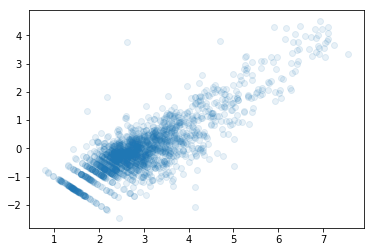

In [79]:
plt.scatter(results,y_train-results,alpha=.1)
# plt.plot(np.linspace(0,10,10),np.linspace(0,10,10))

In [80]:
rcv.score(X_test, y_test)

0.10610178002533499

In [81]:
# try Lasso

In [82]:
lcv = LassoCV(cv=5)
lcv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [83]:
lcv.score(X_train, y_train)

0.03997930305238129

In [84]:
lcv.score(X_test, y_test)

0.07547475580898266

In [85]:
# df3
X = df3.loc[:, df3.columns != 'upvotes_logged']
y = df3['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [86]:
rcv = RidgeCV(alphas=(0.1,1,2,3,50.0), cv=5)

In [87]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(0.1, 1, 2, 3, 50.0), cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [88]:
rcv.alpha_

3

In [89]:
rcv.score(X_train, y_train)

0.45651101527879134

In [90]:
rcv.score(X_test, y_test)

0.0396769983241434

In [91]:
# df4

In [92]:
X = df4.loc[:, df4.columns != 'upvotes_logged']
y = df4['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [93]:
rcv = RidgeCV(alphas=(0.1, 1,10, 20.0, 100), cv=5)

In [94]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(0.1, 1, 10, 20.0, 100), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [95]:
rcv.alpha_

100

In [96]:
rcv.score(X_train, y_train)

0.0737454513643685

In [97]:
rcv.score(X_test, y_test)

0.09455049031099128

In [98]:
# df5

In [99]:
X = df5.loc[:, df5.columns != 'upvotes_logged']
y = df5['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [100]:
rcv = RidgeCV(alphas=(186.0, 187.0, 189.0, 190.0), cv=5)

In [101]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(186.0, 187.0, 189.0, 190.0), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [102]:
rcv.alpha_

186.0

In [103]:
rcv.score(X_train, y_train)

0.06635455551976177

In [104]:
rcv.score(X_test, y_test)

0.025494504139539242

In [105]:
# df6 (BEST)

In [106]:
X = df6.loc[:, df6.columns != 'upvotes_logged']
y = df6['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [107]:
rcv = RidgeCV(alphas=(0.1,1,2,3, 4,5,6,7, 10,1000), cv=5)

In [108]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(0.1, 1, 2, 3, 4, 5, 6, 7, 10, 1000), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [109]:
rcv.alpha_

2

In [110]:
rcv.score(X_train, y_train)

0.20237334167217202

In [111]:
rcv.score(X_test, y_test)

0.11224435472709404

In [112]:
# df7

In [113]:
X = df7.loc[:, df7.columns != 'upvotes_logged']
y = df7['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [114]:
rcv = RidgeCV(alphas=(30.75,31.0,31.25), cv=5)

In [115]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(30.75, 31.0, 31.25), cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [116]:
rcv.alpha_

31.25

In [117]:
rcv.score(X_train, y_train)

0.10690882578255345

In [118]:
rcv.score(X_test, y_test)

0.10272982157820099

In [119]:
# df8

In [120]:
X = df7.loc[:, df7.columns != 'upvotes_logged']
y = df7['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [121]:
rcv = RidgeCV(alphas=(30.75,31.0,31.25), cv=5)

In [122]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(30.75, 31.0, 31.25), cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [123]:
rcv.alpha_

31.25

In [124]:
rcv.score(X_train, y_train)

0.10690882578255345

In [125]:
rcv.score(X_test, y_test)

0.10272982157820099

In [126]:
# df9

In [127]:
X = df9.loc[:, df9.columns != 'upvotes_logged']
y = df9['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [128]:
rcv = RidgeCV(alphas=(9.5,10,10.5), cv=5)

In [129]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(9.5, 10, 10.5), cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [130]:
rcv.alpha_

9.5

In [131]:
rcv.score(X_train, y_train)

0.12926006409606783

In [132]:
rcv.score(X_test, y_test)

0.10986896685722845

In [133]:
# df10

In [134]:
X = df10.loc[:, df10.columns != 'upvotes_logged']
y = df10['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [135]:
rcv = RidgeCV(alphas=(1,1.25,1.5,1.75,2.1,2.25), cv=5)

In [136]:
rcv.fit(X_train, y_train)

RidgeCV(alphas=(1, 1.25, 1.5, 1.75, 2.1, 2.25), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [137]:
rcv.alpha_

1.75

In [138]:
rcv.score(X_train, y_train)

0.23256932630057736

In [139]:
rcv.score(X_test, y_test)

0.10902164902943856

In [140]:
# df11

In [141]:
X = df11.loc[:, df11.columns != 'upvotes_logged']
y = df11['upvotes_logged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
rcv = RidgeCV(alphas=(1,5,33,66,80,100), cv=5)
fit = rcv.fit(X_train, y_train)
rcv.alpha_

80

In [142]:
coefs = []
for item1, item2 in zip(df11.columns.values,rcv.coef_):
    tup = (item1, item2)
    coefs.append(tup)

sorted(coefs, key=lambda x: x[1])

[('missing', -0.2356598259887111),
 ('military', -0.22226126342546676),
 ('khashoggi', -0.2142663523400846),
 ('jamal', -0.21115560226158106),
 ('visit', -0.2093393739690576),
 ('trade deal', -0.18843357341602493),
 ('iran', -0.18605576182338376),
 ('government', -0.18363788060194022),
 ('north', -0.17420257332837388),
 ('saudi', -0.17301305361055627),
 ('health', -0.16534662295049113),
 ('prison', -0.1624382408427186),
 ('officers', -0.1615202666842002),
 ('australian', -0.16149556038001134),
 ('dies', -0.1550624459297385),
 ('climate change', -0.15080628643413035),
 ('india', -0.14176418657475567),
 ('change', -0.13821896472416434),
 ('prime minister', -0.13743027298693955),
 ('sydney opera', -0.13622831753196424),
 ('public', -0.13462965253760276),
 ('ambassador', -0.12794997587478327),
 ('british', -0.12715319863508254),
 ('prize', -0.12651118905184566),
 ('years', -0.12401447090042242),
 ('west', -0.12388477232419813),
 ('worlds', -0.1220100855719762),
 ('reportedly', -0.121659655

In [143]:
rcv.score(X_train, y_train)

0.13856220288101273

In [144]:
rcv.score(X_test, y_test)

0.1213499723599446

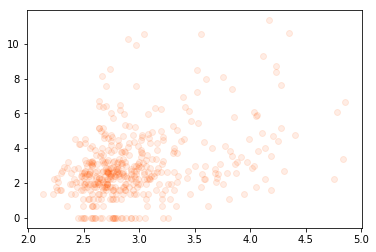

In [145]:
pred = rcv.predict(X_test)
plt.scatter(pred,y_test,alpha=.1, color = '#FF5700')

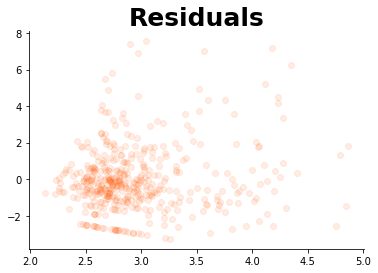

In [146]:
plt.scatter(pred,y_test-pred,alpha=.1, color = '#FF5700')
plt.title('Residuals', fontsize = 25, weight = 'bold')
sns.despine();

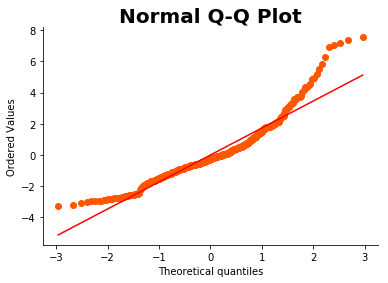

In [147]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(y_test-pred, dist="norm", plot=plt)
ax.get_lines()[0].set_color('#FF5700')
plt.title('Normal Q-Q Plot', fontsize = 20, weight = 'bold')
sns.despine();

In [148]:
np.sqrt(np.mean((pred - y_test)**2))

1.7933432143799197

# 12. Top Word Distributions

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


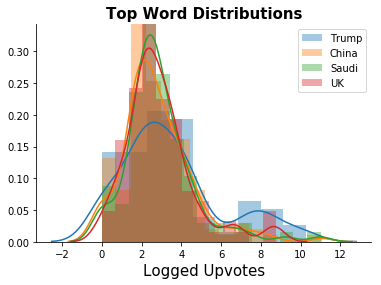

In [149]:
df12 = df12[['upvotes_logged','trump','china','saudi','uk']]
df121 = df12[df12.trump > 0].reset_index(drop=True)
df122 = df12[df12.china > 0].reset_index(drop=True)
df123 = df12[df12.saudi > 0].reset_index(drop=True)
df124 = df12[df12.uk > 0].reset_index(drop=True)

sns.distplot(df121['upvotes_logged'], label = 'Trump')
sns.distplot(df122['upvotes_logged'], label = 'China')
sns.distplot(df123['upvotes_logged'], label = 'Saudi')
sns.distplot(df124['upvotes_logged'], label = 'UK')

plt.title('Top Word Distributions', fontsize = 15, weight = 'bold')
plt.xlabel('Logged Upvotes', fontsize = 15)

plt.legend()
sns.despine();